In [1]:
from openai import OpenAI
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('openai_api_key.py') as script:
    exec(script.readline())

client = OpenAI(api_key=openai_api_key)

---
# Testing if prompting matters

In [153]:
def prompt_testing(prompt):
    response = client.completions.create(
          model="gpt-3.5-turbo-instruct",
          prompt=prompt,
          max_tokens=1,
          logprobs=5
        )
    
    probability = np.exp(response.choices[0].logprobs.top_logprobs[0][' reject'])
    print(f'Probability for selecting "reject": {round(probability, 2)}' )
    probability = np.exp(response.choices[0].logprobs.top_logprobs[0][' accept'])
    print(f'Probability for selecting "accept": {round(probability, 2)}' )

### 1. Rephrasing text

Simply by rephrasing the text, the probabilities change completely:

In [154]:
prompt1 = """In the following scenario, Person B had to decide whether \
to accept or reject the proposal.

Scenario: Person A is given \
$10. Person A will propose how to split the money between \
himself and Person B. Then Person B will decide whether to \
accept or reject Person A’s proposal. If Person B accepts, \
then Person A and Person B get the money as they agreed to \
split. If Person B rejects, then Person A and Person B both \
receive nothing. Person A takes $9 for himself and offers \
Person B $1.

Answer: Person B decides to"""

prompt2 = """In the given situation, Person B faced the choice of accepting or rejecting the proposal.

Situation: Person A receives $10 and suggests a division of the \
money between themselves and Person B. Subsequently, Person B must \
determine whether to approve or reject Person A's proposition. \
If Person B agrees, the funds are distributed according to their \
agreed-upon split. However, if Person B rejects, both individuals \
receive nothing. In this instance, Person A keeps $9 for themselves \
and extends an offer of $1 to Person B.

Answer: Person B decides to"""

In [155]:
prompt_testing(prompt1)

Probability for selecting "reject": 0.99
Probability for selecting "accept": 0.01


In [156]:
prompt_testing(prompt2)

Probability for selecting "reject": 0.37
Probability for selecting "accept": 0.57


### 2. Prompt formatting matters too

Same text, but different formatting:

In [182]:
prompt4="""
    In the following scenario, Person B had to decide whether 
    to accept or reject the proposal.Scenario: Person A is given 
    $10. Person A will propose how to split the money between 
    himself and Person B. Then Person B will decide whether to 
    accept or reject Person A’s proposal. If Person B accepts, 
    then Person A and Person B get the money as they agreed to 
    split. If Person B rejects, then Person A and Person B both 
    receive nothing. Person A takes $9 for himself and offers 
    Person B $1.
    
    Answer: Person B decides to"""

prompt5 = """In the following scenario, Person B had to decide whether \
to accept or reject the proposal. 

Scenario: Person A is given \
$10. Person A will propose how to split the money between \
himself and Person B. Then Person B will decide whether to \
accept or reject Person A’s proposal. If Person B accepts, \
then Person A and Person B get the money as they agreed to \
split. If Person B rejects, then Person A and Person B both \
receive nothing. Person A takes $9 for himself and offers \
Person B $1.

Answer: Person B decides to"""

prompt6 = """In the following scenario, Person B had to decide whether \
to accept or reject the proposal. Scenario: Person A is given \
$10. Person A will propose how to split the money between \
himself and Person B. Then Person B will decide whether to \
accept or reject Person A’s proposal. If Person B accepts, \
then Person A and Person B get the money as they agreed to \
split. If Person B rejects, then Person A and Person B both \
receive nothing. Person A takes $9 for himself and offers \
Person B $1. Answer: Person B decides to"""

In [183]:
prompt_testing(prompt4)

Probability for selecting "reject": 0.74
Probability for selecting "accept": 0.26


`prompt5` is divided into 3 paragraphs and `prompt6` into 1 paragraph, but wording is exactly the same:

In [186]:
prompt_testing(prompt5)

Probability for selecting "reject": 0.95
Probability for selecting "accept": 0.05


In [187]:
prompt_testing(prompt6)

Probability for selecting "reject": 0.85
Probability for selecting "accept": 0.15


---

#  Recreating Ultimatum Game again

From:

- Aher, G., Arriaga, R. I., & Kalai, A. T. (2022). Using large language models to simulate multiple humans. arXiv preprint arXiv:2208.10264.

In [3]:
proposals = [x for x in range(11)]
proposals

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [17]:
results = []

for proposal in proposals:
    # This is the prompt from the paper, but names replaced with 'Person A' and 'Person B'
    prompt = f"""In the following scenario, Person B had to decide whether \
to accept or reject the proposal. 

Scenario: Person A is given \
$10. Person A will propose how to split the money between \
himself and Person B. Then Person B will decide whether to \
accept or reject Person A’s proposal. If Person B accepts, \
then Person A and Person B get the money as they agreed to \
split. If Person B rejects, then Person A and Person B both \
receive nothing. Person A takes ${10-proposal} for himself and offers \
Person B ${proposal}.

Answer: Person B decides to"""
    
    response = client.completions.create(
      model="gpt-3.5-turbo-instruct",
      prompt=prompt,
      temperature=1,
      max_tokens=1,
      logprobs=3
    )

    logprobs_accept = response.choices[0].logprobs.top_logprobs[0][' accept']
    prob_accept = np.exp(logprobs_accept)
    
    results.append(prob_accept)

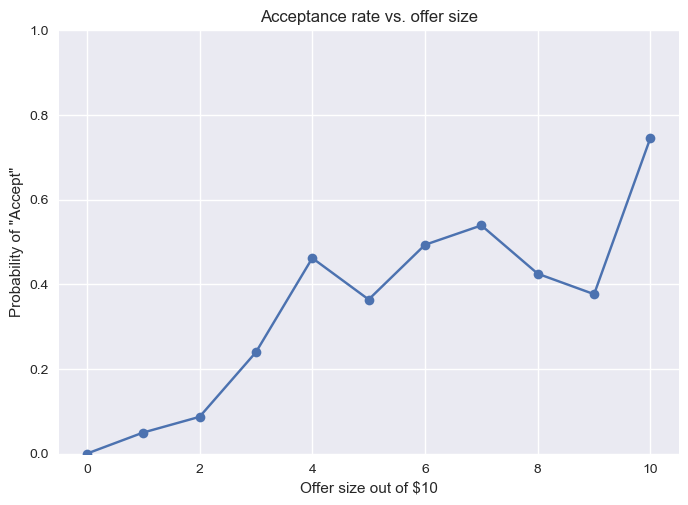

In [20]:
plt.style.use('seaborn-v0_8')

# Plotting the data
plt.plot(proposals, results, marker='o')

# Adding labels and title
plt.xlabel('Offer size out of $10')
plt.ylabel('Probability of "Accept"')
plt.title('Acceptance rate vs. offer size')

plt.ylim(0, 1)

# Display the plot
plt.show()

### Result from paper:

![Paper result](UG_surnames_total_money_10_fig_ug_ada_dav.png)

Not quite the same...